In [1]:
import os
from shutil import copyfile
import cv2 
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot as plt
from random import seed
from random import randint
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import SGD
from tensorflow.keras.utils import img_to_array
import h5py

In [ ]:
def split_train_test(src, train, test):
    fnames = os.listdir(src)
    for (index, fname) in enumerate(fnames):
        source = os.path.join(src, fname)
        if (index % 10) == 0:
            dst = os.path.join(test, fname)
        else:
            dst = os.path.join(train, fname)
        copyfile(source, dst)

In [ ]:
split_train_test(r'D:\AI Project\UTKFaces', r'D:\AI Project\Training', r'D:\AI Project\Testing')

In [2]:
def load_and_return(src, imgsize, age_range):
    loaded_images = []
    loaded_labels = []
    all_filepaths = []
    all_files = os.listdir(src)
    label_counter = 0
    
    for file in all_files:
        all_filepaths.append(os.path.join(src, file))
        
    for path in all_filepaths:
        filename = os.path.basename(path)
        age_label = filename.split('_')
        age_label = int(age_label[0])
        
        status = False

        for index in range(len(age_range)):
            if index < (len(age_range) - 1):
                if age_label >= age_range[index] and age_label < age_range[index + 1]:
                    # print('Here' + ' ' + str(age_range[index + 1])) 
                    loaded_labels.append(index + 1)
                    status = True
                    break
        
        if not status: print(age_label)
        
        img = cv2.imread(path)
        img = cv2.resize(img, (imgsize, imgsize), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img_to_array(img, data_format='channels_last')
        loaded_images.append(img)

    lblBinarizer = LabelBinarizer()
    lblBinarizer.fit(range(1, len(age_range)))
    binarizedLabels = np.array(lblBinarizer.transform(loaded_labels))
    loaded_images = np.array(loaded_images).astype('float')/255.0
    
    return (loaded_images, binarizedLabels)

In [10]:
age_range = [1, 11, 21, 32, 43, 54, 65, 71, 82, 90, 102]

total_classes = len(age_range) - 1

(train_imgs, train_lbls) = load_and_return(r'D:\AI Project\Training', 128, age_range) # Loading training data
(test_imgs, test_lbls) = load_and_return(r'D:\AI Project\Testing', 128, age_range) # Loading testing data


In [2]:
age_range = [1, 11, 21, 32, 43, 54, 65, 71, 82, 90, 102]
# train_lbls.shape

Text(0, 0.5, 'Age = 32')

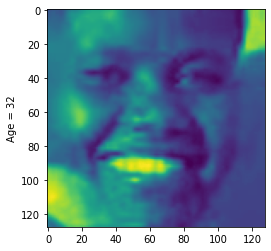

In [6]:
generate = randint(0, len(train_imgs))
plt.imshow(train_imgs[generate])
age = age_range[np.where(train_lbls[generate] == 1)[0][0]]
plt.ylabel(f'Age = {age}')

In [7]:
def getModel(img_dim, num_kernels, classes, num_hidden_neurons, num_of_layers):
    convNet = Sequential()
    convNet.add(Conv2D(num_kernels, (5, 5), input_shape=(img_dim, img_dim, 1), activation='relu'))
    convNet.add(BatchNormalization())
    convNet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    half = int((num_of_layers - 1) / 2)
    
    for i in range(num_of_layers - 1):
        if i != half:
            convNet.add(Conv2D(num_kernels, (5, 5), padding='same', activation='relu'))
        else:
            convNet.add(Conv2D(num_kernels + 32, (3, 3), padding='same', activation='relu'))
        convNet.add(BatchNormalization())
        convNet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
    convNet.add(Flatten())
    convNet.add(Dense(num_hidden_neurons, activation='relu'))
    convNet.add(Dropout(0.5))
    
    convNet.add(Dense(num_hidden_neurons, activation='relu'))
    
    convNet.add(Dense(classes, activation='softmax'))
    convNet.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])
    return convNet

In [8]:
model = getModel(128, 32, total_classes, 256, 5)

In [9]:
model.fit(train_imgs, train_lbls, validation_data=(test_imgs, test_lbls), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
167/167 [==============================] - 891s 5s/step - loss: 1.8039 - accuracy: 0.3815 - val_loss: 2.2653 - val_accuracy: 0.1423
Epoch 2/20
167/167 [==============================] - 948s 6s/step - loss: 1.5102 - accuracy: 0.4583 - val_loss: 1.8363 - val_accuracy: 0.3174
Epoch 3/20
167/167 [==============================] - 1133s 7s/step - loss: 1.4061 - accuracy: 0.4821 - val_loss: 1.5746 - val_accuracy: 0.4111
Epoch 4/20
167/167 [==============================] - 1012s 6s/step - loss: 1.3303 - accuracy: 0.4989 - val_loss: 1.5202 - val_accuracy: 0.4766
Epoch 5/20
167/167 [==============================] - 1086s 6s/step - loss: 1.2780 - accuracy: 0.5144 - val_loss: 1.4410 - val_accuracy: 0.4989
Epoch 6/20
167/167 [==============================] - 1128s 7s/step - loss: 1.2358 - accuracy: 0.5227 - val_loss: 2.0743 - val_accuracy: 0.4588
Epoch 7/20
167/167 [==============================] - 1132s 7s/step - loss: 1.2023 - accuracy: 0.5315 - val_loss: 1.2042 - val_accuracy: 0

In [74]:
import h5py
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save("model1.model")

INFO:tensorflow:Assets written to: model1.model\assets


INFO:tensorflow:Assets written to: model1.model\assets


In [3]:
from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model1.model")

In [4]:
# (testing_imgs, testing_lbls) = load_and_return(r'D:\AI Project\Testing', 128, [3, 8, 15, 22, 25])
loaded_model.compile(loss="categorical_crossentropy", optimizer=SGD(
    learning_rate=0.01), metrics=["accuracy"])
# loss, accuracy = loaded_model.evaluate(test_imgs, test_lbls)

29/29 [==============================] - 12s 415ms/step


Text(0.5, 0, '21')

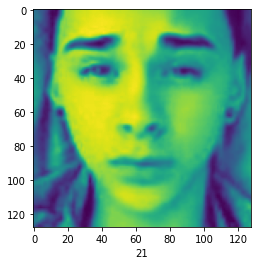

In [41]:
y_pred = model.predict(test_imgs[:900])

Text(0.5, 0, 'Age = 32')

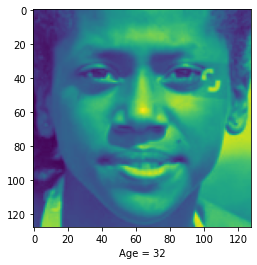

In [100]:
i = randint(0, 900)
plt.imshow(test_imgs[i])
plt.xlabel(f'Age = {age_range[np.argmax(y_pred[i])]}')

In [5]:
def getNormalizedImage(img, imgsize):
    img = cv2.resize(img, (imgsize, imgsize), cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_to_array(img, data_format='channels_last')
    img = (np.array([img])).astype('float')/255.0
    return img

1/1 [==============================] - 0s 33ms/step


Text(0, 0.5, 'Age = 21')

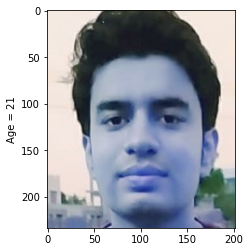

In [31]:
image = cv2.imread(r'D:\2.jpg')
img = getNormalizedImage(image, 128)
y_pred = loaded_model.predict(img)


plt.imshow(image)
plt.ylabel(f'Age = {age_range[np.argmax(y_pred[0])]}')

1/1 [==============================] - 0s 53ms/step


Text(0, 0.5, 'Age = 54')

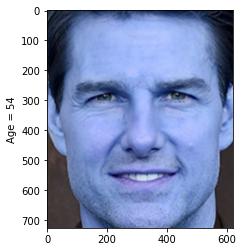

In [35]:
image = cv2.imread(r'D:\tom3.jpg')
img = getNormalizedImage(image, 128)
y_pred = loaded_model.predict(img)


plt.imshow(image)
plt.ylabel(f'Age = {age_range[np.argmax(y_pred[0])]}')

1/1 [==============================] - 0s 41ms/step


Text(0, 0.5, 'Age = 21')

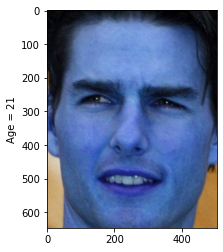

In [34]:
image = cv2.imread(r'D:\tom2.jpg')
img = getNormalizedImage(image, 128)
y_pred = loaded_model.predict(img)


plt.imshow(image)
plt.ylabel(f'Age = {age_range[np.argmax(y_pred[0])]}')

1/1 [==============================] - 0s 45ms/step


Text(0, 0.5, 'Age = 32')

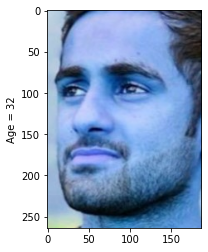

In [10]:
image = cv2.imread(r'D:\1.jpg')
img = getNormalizedImage(image, 128)
y_pred = loaded_model.predict(img)


plt.imshow(image)
plt.ylabel(f'Age = {age_range[np.argmax(y_pred[0])]}')